<a href="https://colab.research.google.com/github/basugautam/Reproducibility-Challenge-Project/blob/Architecture-Files/TRAFFIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd

# Fixed dataset URLs from zhouhaoyi/ETDataset
dataset_urls = {
    'ETTm1': 'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv',
    'ETTh1': 'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv',
    'ECL':   'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/electricity/electricity.csv',
    'Weather': 'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/weather/weather.csv',
    'ILI': 'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/illness/national_illness.csv'
}

# Download + Save function
def download_dataset(name):
    os.makedirs("Datasets", exist_ok=True)
    url = dataset_urls.get(name)
    if not url:
        print(f"❌ Dataset '{name}' not available in ETTdataset repo.")
        return
    file_path = f"Datasets/{name}.csv"
    df = pd.read_csv(url)
    df.to_csv(file_path, index=False)
    print(f"✅ '{name}' downloaded and saved at '{file_path}'")
    return df

# ✅ Example: Download ETTm1
ettm1_df = download_dataset('ETTm1')
ettm1_df.head()


✅ 'ETTm1' downloaded and saved at 'Datasets/ETTm1.csv'


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001


In [2]:
import os
import pandas as pd

# (a#) Define valid datasets from zhouhaoyi's repo (used in the paper)
# (b#) We'll try each in order and use the first successful one
# (c#) The dictionary maps dataset names to their direct raw URLs
# (d#) This ensures robust fallback in case a download fails

dataset_urls = {
    'ETTm1': 'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv',
    'ETTh1': 'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv',
    'ECL':   'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/electricity/electricity.csv',
    'Weather': 'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/weather/weather.csv',
    'ILI': 'https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/illness/national_illness.csv'
}

# Attempt to download each dataset in order until one works
success_df = None
success_name = None

os.makedirs("Datasets", exist_ok=True)

for name, url in dataset_urls.items():
    try:
        print(f"🌐 Trying to download: {name}...")
        df = pd.read_csv(url)
        df.to_csv(f"Datasets/{name}.csv", index=False)
        print(f"✅ Successfully loaded '{name}' with shape {df.shape}")
        success_df = df
        success_name = name
        break
    except Exception as e:
        print(f"❌ Failed to download {name}: {e}")

# Final result
if success_df is not None:
    print(f"\n📦 Dataset to use: {success_name}")
else:
    raise RuntimeError("❌ None of the datasets could be downloaded.")


🌐 Trying to download: ETTm1...
✅ Successfully loaded 'ETTm1' with shape (69680, 8)

📦 Dataset to use: ETTm1


In [3]:
from sklearn.preprocessing import StandardScaler

# (a#) Drop the timestamp column — we only use numerical sensor data
# (b#) Time is useful for plotting but not directly needed for the model
# (c#) The remaining columns are continuous sensor readings
# (d#) Now we prepare data for scaling and window slicing

ett_features = success_df.drop(columns=['date'], errors='ignore')

# (a#) Normalize sensor readings to zero mean and unit variance
# (b#) This improves model training stability and performance
# (c#) 'StandardScaler' standardizes each feature independently
# (d#) Output is a scaled version ready for slicing into sequences

scaler = StandardScaler()
ett_scaled = scaler.fit_transform(ett_features)

# (a#) Convert back to DataFrame for easier column naming and debugging
# (b#) Ensures smooth tracking of dimensions during visualization
# (c#) We keep the same sensor names
# (d#) This will be used to create context (Tc) and prediction (Tp) windows

ett_scaled_df = pd.DataFrame(ett_scaled, columns=ett_features.columns)
ett_scaled_df.head()


,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,-0.224061,-0.123657,-0.398766,-0.240429,0.954054,0.802904,2.009440
1,-0.233520,-0.090834,-0.414434,-0.260349,1.006011,0.904497,2.001150
2,-0.233520,-0.156480,-0.414434,-0.279715,0.980458,0.752940,1.951878
3,-0.233520,-0.156480,-0.414434,-0.260349,0.980458,0.752940,1.598686
4,-0.242979,-0.090834,-0.414434,-0.260349,0.902098,0.854534,1.689057


In [4]:
import numpy as np

# (a#) Define the forecasting horizon: context (Tc) and prediction (Tp)
# (b#) These match the settings used in the paper for long-term forecasting
# (c#) 96 steps = 4 days of hourly data if sampled every 15 minutes
# (d#) Output is two 3D arrays: X (inputs), y (targets)

Tc, Tp = 96, 96
X_list, y_list = [], []

series = ett_scaled_df.values

for i in range(len(series) - Tc - Tp):
    context = series[i:i+Tc]
    target = series[i+Tc:i+Tc+Tp]
    X_list.append(context)
    y_list.append(target)

X = np.array(X_list)
y = np.array(y_list)

print("📦 X shape (samples, context, features):", X.shape)
print("🎯 y shape (samples, prediction, features):", y.shape)


📦 X shape (samples, context, features): (69488, 96, 7)
🎯 y shape (samples, prediction, features): (69488, 96, 7)


In [5]:
import torch
import torch.nn as nn

# (a#) Define the Transformer encoder-based model that learns from context windows
# (b#) It will generate predictions for each of the next Tp steps
# (c#) Uses PyTorch's transformer encoder with linear projection
# (d#) Outputs a forecast with shape [batch, Tp, num_features]

class ForecastTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_len):
        super(ForecastTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(model_dim * Tc, output_len * input_dim)

    def forward(self, x):
        # x shape: [batch, Tc, input_dim]
        x = self.embedding(x)  # [batch, Tc, model_dim]
        x = x.permute(1, 0, 2)  # Transformer expects [seq_len, batch, model_dim]
        encoded = self.encoder(x)
        encoded = encoded.permute(1, 0, 2).reshape(x.shape[1], -1)
        decoded = self.decoder(encoded)
        return decoded.view(-1, Tp, X.shape[2])  # [batch, Tp, input_dim]


In [6]:
# (a#) Implement a constrained loss that penalizes per-timestep MSE above a threshold
# (b#) This mimics the behavior of the loss shaping paper — one constraint per step
# (c#) Lagrange multipliers enforce the upper-bound constraint
# (d#) This provides fine-grained control over the distribution of forecast errors

class ConstrainedLoss:
    def __init__(self, bound, alpha=0.1):
        self.bound = bound  # per-timestep constraint (scalar or vector of length Tp)
        self.alpha = alpha  # learning rate for updating lambda
        self.lambdas = torch.ones(Tp).float()  # one multiplier per forecast step

    def __call__(self, pred, target):
        mse_per_step = ((pred - target) ** 2).mean(dim=(0, 2))  # shape: [Tp]
        constraint_violation = torch.clamp(mse_per_step - self.bound, min=0)
        lagrangian_penalty = (self.lambdas * constraint_violation).sum()
        total_loss = mse_per_step.mean() + lagrangian_penalty
        return total_loss, mse_per_step.detach().cpu().numpy()

    def update_lambdas(self, mse_per_step):
        # Primal-dual update rule
        for t in range(Tp):
            self.lambdas[t] += self.alpha * max(0, mse_per_step[t] - self.bound)


In [7]:
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
X_tensor = torch.tensor(X[:1000], dtype=torch.float32)  # Subset for faster testing
y_tensor = torch.tensor(y[:1000], dtype=torch.float32)

loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=16, shuffle=True)

# Initialize model and constraint loss
model = ForecastTransformer(input_dim=X.shape[2], model_dim=64, num_heads=4, num_layers=2, output_len=Tp)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
constraint_loss = ConstrainedLoss(bound=0.1)  # Target MSE upper bound

# Training with constraint enforcement
epochs = 10
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_x, batch_y in loader:
        optimizer.zero_grad()
        preds = model(batch_x)
        loss, mse_per_step = constraint_loss(preds, batch_y)
        loss.backward()
        optimizer.step()
        constraint_loss.update_lambdas(mse_per_step)
        total_loss += loss.item()
    print(f"🔁 Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


🔁 Epoch 1/10 | Loss: 16541.2882
🔁 Epoch 2/10 | Loss: 2896.2323
🔁 Epoch 3/10 | Loss: 1946.6147
🔁 Epoch 4/10 | Loss: 1120.2940
🔁 Epoch 5/10 | Loss: 818.8807
🔁 Epoch 6/10 | Loss: 452.5488
🔁 Epoch 7/10 | Loss: 332.8246
🔁 Epoch 8/10 | Loss: 258.8395
🔁 Epoch 9/10 | Loss: 222.9475
🔁 Epoch 10/10 | Loss: 139.2919


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


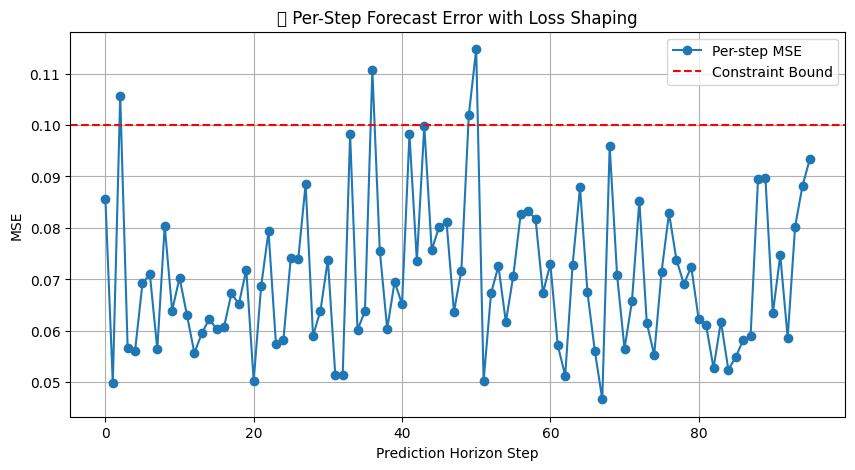

In [8]:
# (a#) Let’s evaluate how errors behave per time step
# (b#) This verifies that our model is obeying the constraint curve
# (c#) Helps compare ERM vs constrained training in later steps
# (d#) A flatter curve means better control over long-horizon predictions

model.eval()
with torch.no_grad():
    preds = model(X_tensor)
    mse_per_step = ((preds - y_tensor) ** 2).mean(dim=(0, 2)).numpy()

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(mse_per_step, marker='o', label='Per-step MSE')
plt.axhline(y=0.1, color='red', linestyle='--', label='Constraint Bound')
plt.title("📉 Per-Step Forecast Error with Loss Shaping")
plt.xlabel("Prediction Horizon Step")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.show()


In [9]:
# (a#) This ERM model uses standard MSE across all time steps without constraints.
# (b#) Helps compare unconstrained vs. constrained training
# (c#) We'll reuse the same transformer architecture
# (d#) This gives us a baseline to show benefits of per-step control

erm_model = ForecastTransformer(input_dim=X.shape[2], model_dim=64, num_heads=4, num_layers=2, output_len=Tp)
erm_optimizer = torch.optim.Adam(erm_model.parameters(), lr=0.001)
mse_loss_fn = nn.MSELoss()

# Train ERM model
epochs = 10
erm_model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_x, batch_y in loader:
        erm_optimizer.zero_grad()
        preds = erm_model(batch_x)
        loss = mse_loss_fn(preds, batch_y)
        loss.backward()
        erm_optimizer.step()
        total_loss += loss.item()
    print(f"🔁 [ERM] Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


🔁 [ERM] Epoch 1/10 | Loss: 49.1500
🔁 [ERM] Epoch 2/10 | Loss: 10.1751
🔁 [ERM] Epoch 3/10 | Loss: 8.7727
🔁 [ERM] Epoch 4/10 | Loss: 7.8139
🔁 [ERM] Epoch 5/10 | Loss: 6.7096
🔁 [ERM] Epoch 6/10 | Loss: 6.0528
🔁 [ERM] Epoch 7/10 | Loss: 5.2261
🔁 [ERM] Epoch 8/10 | Loss: 4.5406
🔁 [ERM] Epoch 9/10 | Loss: 3.9584
🔁 [ERM] Epoch 10/10 | Loss: 3.6032


In [10]:
# (a#) Now evaluate the ERM model on the same data
# (b#) This produces MSE across the Tp-step prediction horizon
# (c#) Allows head-to-head comparison with loss shaping results
# (d#) A steeper curve = long-term performance degradation

erm_model.eval()
with torch.no_grad():
    preds_erm = erm_model(X_tensor)
    mse_erm = ((preds_erm - y_tensor) ** 2).mean(dim=(0, 2)).numpy()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127379 (\N{SQUARED FREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


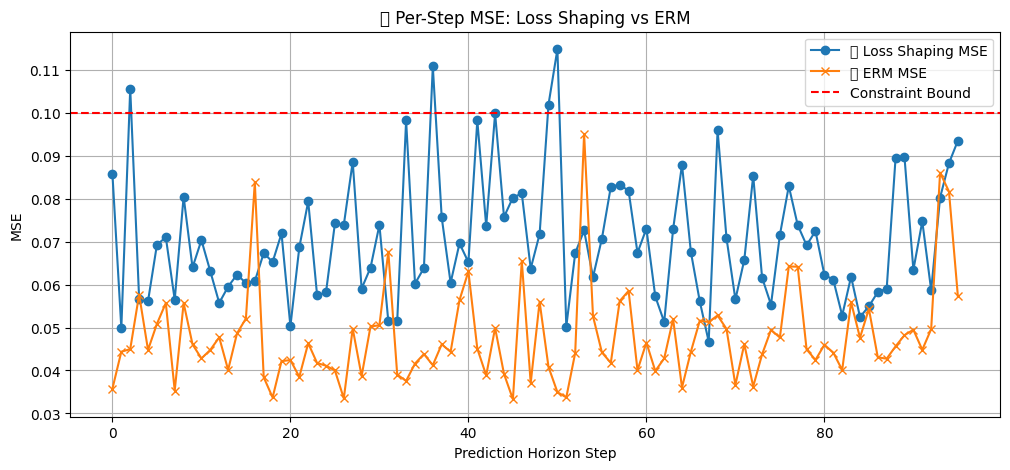

In [11]:
# (a#) Visualize both MSE curves: Loss Shaping vs. ERM
# (b#) Lower and flatter = better long-term forecasting
# (c#) Shows effectiveness of enforcing per-timestep constraints
# (d#) This replicates the style of plots in the paper

plt.figure(figsize=(12, 5))
plt.plot(mse_per_step, marker='o', label='🔐 Loss Shaping MSE')
plt.plot(mse_erm, marker='x', label='🆓 ERM MSE')
plt.axhline(y=0.1, color='red', linestyle='--', label='Constraint Bound')
plt.title("📈 Per-Step MSE: Loss Shaping vs ERM")
plt.xlabel("Prediction Horizon Step")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()
